In [1]:
import numpy as np
import sys
from os.path import expanduser
from scipy import ndimage
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.wcs import WCS
import matplotlib
import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
import warnings
warnings.filterwarnings('ignore')

## Relative folder

In [2]:
home = expanduser("~")
datafolder=home+'/Desktop/mrk79/'  #The folder containing your .fits file
print(datafolder)

/home/apostolis/Desktop/mrk79/


## Open fits file

In [3]:
mrk79_file='COcube.fits' #.fits file name
mrk79_fits=fits.open(datafolder+mrk79_file)[0]

## Fits header

In [4]:
mrk79_header=mrk79_fits.header
mrk79_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                   97                                                  
NAXIS2  =                   97                                                  
NAXIS3  =                  190                                                  
NAXIS4  =                    1                                                  
DATAMIN = -0.6655395496637E-02         /                                        
DATAMAX =  0.2891516312957E-01         /                                        
BUNIT   = 'Jy/beam     '               /                                        
CTYPE1  = 'RA---ARC    '               /                                        
CRVAL1  =  0.1156366666667E+03         /                                        
CDELT1  = -0.1731111137690E-

## Data

In [5]:
mrk79_data=mrk79_fits.data
print(f'Shape of data is {mrk79_data.shape}, so this is not a cube, it has an extra dimension without a reason')
mrk79_data=mrk79_data[0]
print(f'Shape of data is {mrk79_data.shape}, seems fine, the dimensions is (z,y,x) (there is a (computation speed) reason for this, so it is better to keep this structure)')

Shape of data is (1, 190, 97, 97), so this is not a cube, it has an extra dimension without a reason
Shape of data is (190, 97, 97), seems fine, the dimensions is (z,y,x) (there is a (computation speed) reason for this, so it is better to keep this structure)


### Calculate the coordinates
From the header the z coordinate has velocity dimensions ```CTYPE3  = 'VRAD'``` in km/s ```CUNIT3  = 'km/s'```

From the header the x,y coordinates has RA/DEC dimensions ```CTYPE1  = 'RA---ARC'```,```CTYPE2  = 'DEC--ARC'``` in degrees```CUNIT1  = 'deg'```

In [6]:
dx = np.abs(mrk79_header['CDELT1'])*3600 #arcsec
dy = np.abs(mrk79_header['CDELT2'])*3600 #arcsec
dv = mrk79_header['CDELT3'] #km/s

xx=np.linspace(-mrk79_data.shape[2]*dx/2.,mrk79_data.shape[2]*dx/2.,mrk79_header['NAXIS1']) #arcsec
yy=np.linspace(-mrk79_data.shape[1]*dx/2.,mrk79_data.shape[1]*dx/2.,mrk79_header['NAXIS2']) #arcsec

b=mrk79_header['CRVAL3']-mrk79_header['CRPIX3']*dv #zero point velocity
vv=np.linspace(b+dv,b+dv*mrk79_header['NAXIS3'],mrk79_header['NAXIS3'])  #velocity channels


### Make some plots

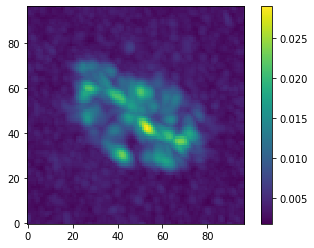

In [7]:
mrk79_max = np.nanmax(mrk79_data,axis=0) #collapse the cube along 0 dimension (velocity) by keeping only the maximum velocities 
plt.imshow(mrk79_max,origin='low')
plt.colorbar()# Image plot, dimensions are pixels

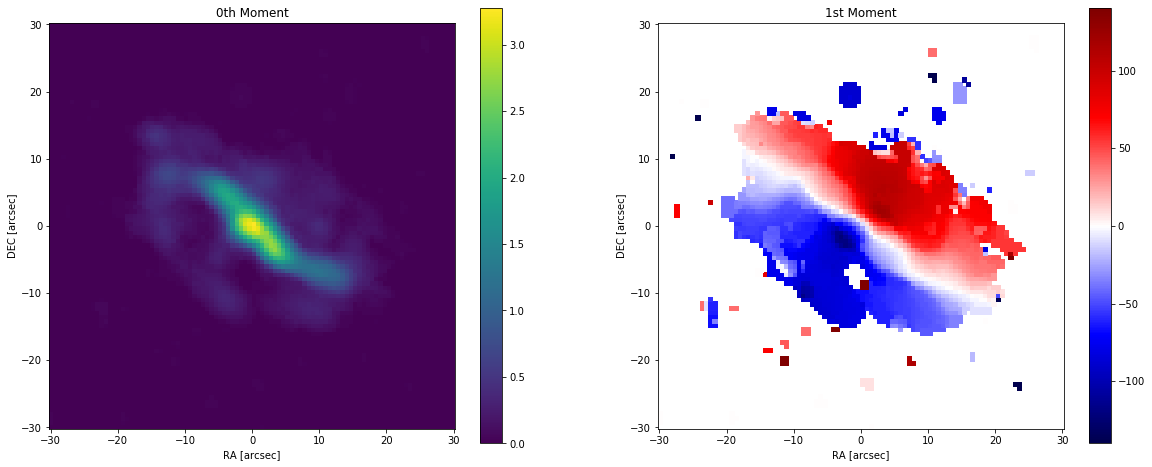

In [8]:
sigma=9.3859574E-4 #noise [Jy/beam]
fig, axes = plt.subplots(1,2,figsize=(20,8))
mrk79_mom0 = np.nansum(np.where(mrk79_data>=5*sigma,mrk79_data,0),axis=0)*np.abs(dv) #collapse the cube along 0 dimension (velocity) by summing (zeroth moment)
vv2=np.linspace(0,0,mrk79_header["NAXIS3"])
for i in range(190):
    vv2[i]=np.where(-300<=vv[i] and vv[i]<=300,vv[i],0)
mrk79_mom1=np.nansum(vv2[:,None,None]*np.where(mrk79_data>=5*sigma,mrk79_data,0),axis=0)/(mrk79_mom0/np.abs(dv)) #first moment
p0=axes[0].pcolormesh(xx,yy,mrk79_mom0,vmin=0)
axes[0].set(aspect=1,xlabel='RA [arcsec]',ylabel='DEC [arcsec]',title='0th Moment')
fig.colorbar(p0, ax=axes[0])

p1=axes[1].pcolormesh(xx,yy,mrk79_mom1,vmin=-140,vmax=140,cmap='seismic')
axes[1].set(aspect=1,xlabel='RA [arcsec]',ylabel='DEC [arcsec]',title='1st Moment')
fig.colorbar(p1, ax=axes[1])


### Extra: Calculate the intrinsic dimensions

arcsec to kpc conversion: 0.4630279249450416 kpc / arcsec
distance to mrk79: 99.79205841490912 Mpc


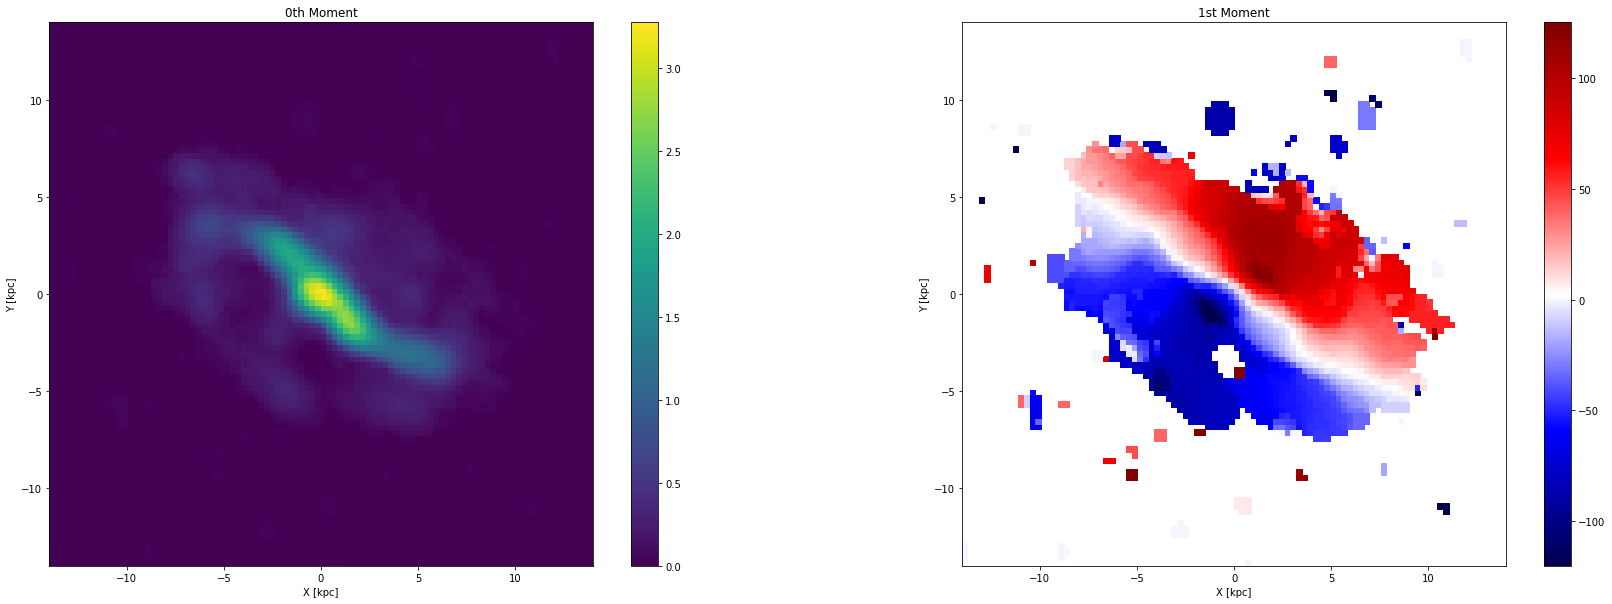

In [9]:
import astropy.units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=67.8, Om0=0.3,Ode0=0.7) #create a cosmology
z=0.02219  #redshit
D=cosmo.luminosity_distance(z) #distance to the object
arctokpc = (cosmo.angular_diameter_distance(z=z)/206265).to(u.kpc)/u.arcsec
print("arcsec to kpc conversion:",arctokpc)
ak=arctokpc.value
print("distance to mrk79:",D)

xx_kpc=xx*ak
yy_kpc=yy*ak

fig, axes = plt.subplots(1,2,figsize=(30,10))

p0=axes[0].pcolormesh(xx_kpc,yy_kpc,mrk79_mom0)
axes[0].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='0th Moment')
fig.colorbar(p0, ax=axes[0])

p1=axes[1].pcolormesh(xx_kpc,yy_kpc,mrk79_mom1,vmin=-120,vmax=125,cmap='seismic')
axes[1].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='1st Moment')
fig.colorbar(p1, ax=axes[1])

## Position Velocity Plots

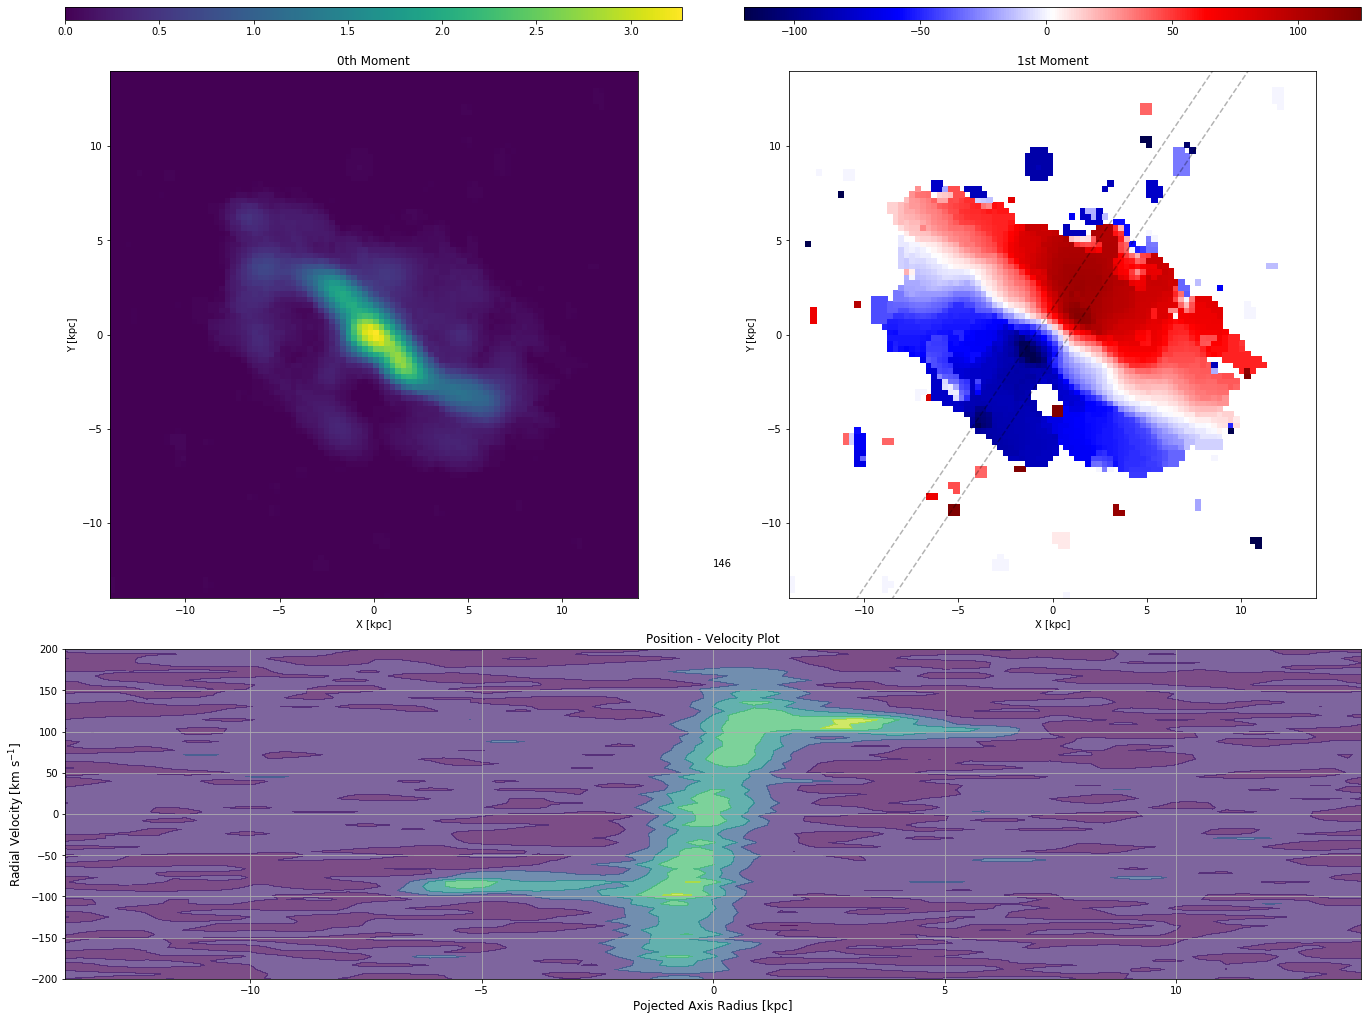

In [10]:
import matplotlib.gridspec as gridspec

papvds = [146]
dx_kpc=(dx)*ak #dx in kpc
slit=0.9377271654521E-03*ak*3600 #slit width in kpc

limy=[np.min(yy_kpc),np.max(yy_kpc)]
limv=[-200,200]

Nplots=len(papvds)
Ncubes = 1
fig = plt.figure(figsize=(20,10+5*Nplots))
gs=gridspec.GridSpec(2+Nplots, 2*Ncubes, height_ratios=[0.02,0.8]+[0.5]*Nplots, width_ratios=[0.8,0.8]*Ncubes)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.175)

ipx=0
axmom0 = fig.add_subplot(gs[1,ipx])
caxmom0 = fig.add_subplot(gs[0,ipx])
ipx=ipx+1
axmom1 = fig.add_subplot(gs[1,ipx])
caxmom1 = fig.add_subplot(gs[0,ipx])

cm0=axmom0.pcolormesh(xx_kpc,yy_kpc,mrk79_mom0)
plt.colorbar(cm0,cax=caxmom0,orientation='horizontal').ax.tick_params(labelsize=10)
axmom0.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='0th Moment')  

cm1=axmom1.pcolormesh(xx_kpc,yy_kpc,mrk79_mom1,vmin=-120,vmax=125,cmap='seismic')
plt.colorbar(cm1,cax=caxmom1,orientation='horizontal').ax.tick_params(labelsize=10)  
axmom1.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='1st Moment')   

ithick = int(round(slit/dx_kpc)) #number of pixels which are going to collapse (inside the slit)
ixc = round(mrk79_data.shape[2]/2) #where is the center in pixels

for j,papvd in enumerate(papvds):
    
    #Create and Plot the Slit(s)
    def yslit_low(x): return slit/(2*np.cos(np.radians(papvd+90))) +x*np.tan(np.radians(papvd+90))
    def yslit_high(x): return -slit/(2*np.cos(np.radians(papvd+90))) +x*np.tan(np.radians(papvd+90))
    axmom1.plot(xx_kpc,yslit_low(xx_kpc),'--',alpha=0.3, color='black')
    axmom1.plot(xx_kpc,yslit_high(xx_kpc),'--',alpha=0.3, color='black')
    axmom1.set(xlim=[np.min(xx_kpc),np.max(xx_kpc)],ylim=[np.min(yy_kpc),np.max(yy_kpc)])   

    axpvd = fig.add_subplot(gs[2+j,:])
    axpvd.text(x=np.mean(limy),y=300,s="{}".format(papvd))
    axpvd.set(title='Position - Velocity Plot')
    axpvd.set_xlabel('Pojected Axis Radius [kpc]',fontsize=12)
    axpvd.set_ylabel(r'Radial Velocity [km s$^{-1}$]',fontsize=12)

    axpvd.set_xlim(limy)
    axpvd.set_ylim(limv)
    axpvd.grid(True)
    
    #Create the Position-Velocity Graph
    rotcube=ndimage.interpolation.rotate(mrk79_data,papvd+180,axes=(2,1),reshape=False) #rotate the cube along 0 dimension
    
    #collapse the slit by summing 
    pvd_cube = np.nansum(rotcube[:,:,ixc-int(ithick/2):ixc+int(ithick/2)],axis=2)
    ppvd_res=axpvd.contourf(yy_kpc,vv,pvd_cube,alpha=0.7,vmin=0)

### 2nd Moment

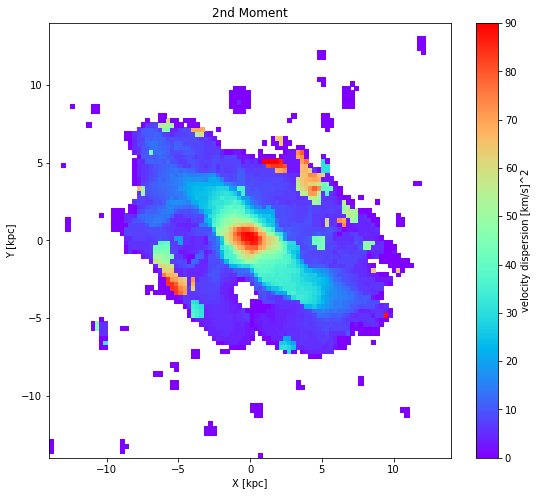

In [11]:
mrk79_mom2=np.sqrt(np.nansum(np.where(mrk79_data>=5*sigma,mrk79_data,0)*(vv2[:,None,None]-mrk79_mom1)**2,axis=0)/((mrk79_mom0)/np.abs(dv)))
plt.figure(figsize=(9,8))
mom2=plt.pcolormesh(xx_kpc,yy_kpc,mrk79_mom2,vmin=0,vmax=90, cmap='rainbow')
plt.xlabel("X [kpc]"), plt.ylabel("Y [kpc]")
plt.title("2nd Moment")
plt.colorbar(label='velocity dispersion [km/s]^2')


### Inclination & Mass

In [12]:
from astropy import constants as const

GG=const.G.to('kpc3 / (kg s2)')
G=GG.value
vmax=122 #maximum rotational velocity corrected for inclination (HyperLeda)
vmax_kpc=(vmax*(u.km/u.s)).to(u.kpc/u.s)
a=(30.90)*ak #semi-major axis in kpc (2MASS)
"""
    a=(30.90)*ak #semi-major axis in kpc (2MASS)
    da=0.33*ak
    b=(16.068)*ak #semi-minor axis in kpc (2MASS)
    db=0.33*ak
    sini=np.sqrt(1-(b/a)**2) #inclination
    dsini=(b/(a**2*sini))*np.sqrt((da*b/a)**2 + db**2)
    di=np.rad2deg(np.arcsin(dsini))
"""
    
sini=np.sin(np.deg2rad(36.7)) #<---This is the inclination

print("the inclination is i =","{:.4}".format(np.rad2deg(np.arcsin(sini))))  #,"+-","{:.2}".format(di),"deg")

Mkg=(a*(vmax_kpc.value)**2)/G
Msun=Mkg/const.M_sun.value

print("Mass of mrk79 =","{:.2e}".format(Msun),"M_sun")

the inclination is i = 36.7
Mass of mrk79 = 4.95e+10 M_sun


### Calculate the a parameter from the maximum velocity 

 a0  =  3.79 kpc


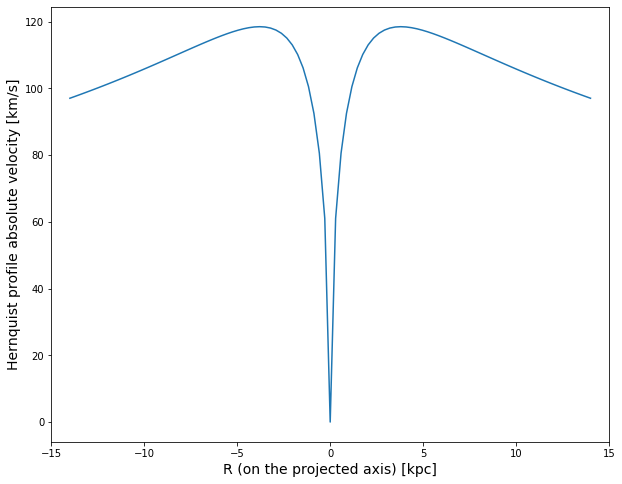

In [13]:
rr=yy_kpc
for a0 in enumerate(rr):
    vc=np.sqrt(G*Mkg*np.abs(rr))/(np.abs(rr)+np.abs(a0[1]))
    vc=((vc*(u.kpc/u.s)).to(u.km/u.s)).value
    if (vmax-4.7)<=np.max(vc) and np.max(vc)<=(vmax+4.7): 
        break
plt.figure(figsize=(10,8))
plt.plot(rr,vc)
plt.xlim(-15,15), plt.xlabel("R (on the projected axis) [kpc]",fontsize=14), plt.ylabel("Hernquist profile absolute velocity [km/s]",fontsize=14)
print(" a0  = ","{:.3}".format(np.abs(a0[1])),"kpc")


### Fitting of 1st Moment with the Hernquist profile

parameter a calculated from least squares fiting a= 5.69 kpc


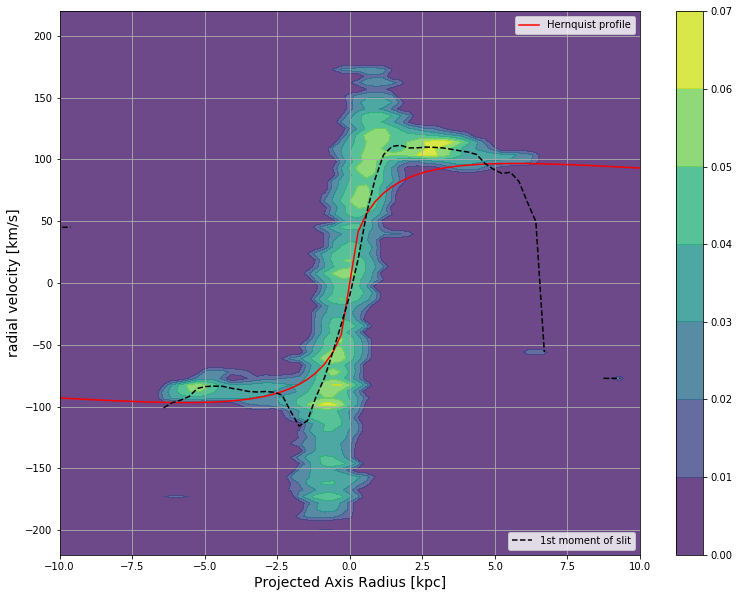

In [14]:
#Removing less than 5*sigma Intensities 
pvd_cubec=np.nansum(np.where(rotcube[:,:,ixc-int(ithick/2):ixc+int(ithick/2)]>=5*sigma,rotcube[:,:,ixc-int(ithick/2):ixc+int(ithick/2)],0),axis=2)

#if you don't want to remove low intensities just uncomment the line below 
#pvd_cubec=pvd_cube

mom0slit=np.nansum(pvd_cubec,axis=0)*np.abs(dv)
mom1slit=np.nansum(vv[:,None]*pvd_cubec,axis=0)/(mom0slit/np.abs(dv))


def hern(r,a0): #Hernquist model velocity function
    vc=np.sqrt(G*Mkg*np.abs(r))/(np.abs(r)+np.abs(a0))
    vc=((vc*(u.kpc/u.s)).to(u.km/u.s)).value
    return vc

def errfhern(vh,m1_slit): #error function of one position
    errf=np.nansum(np.abs(vh-np.abs(m1_slit))**2)
    return errf

param_a=np.linspace(0,np.max(yy_kpc),len(yy_kpc)) #parameter a
sum_err=np.linspace(0,0,len(param_a))

for j, a00 in enumerate(param_a):
    vhern=hern(yy_kpc,a00)
    
    for i in range(len(yy_kpc)):
        sum_err[j]=sum_err[j]+errfhern(vhern[i],mom1slit[i])
    sum_err[j]=((sum_err[j])/len(yy_kpc))
    
index_of_min_a0=np.where(sum_err==np.nanmin(sum_err))  
a0_min=param_a[index_of_min_a0]
plt.figure(figsize=(13,10))
line1=plt.plot(yy_kpc,np.where(yy_kpc<=0,-hern(yy_kpc,a0_min),hern(yy_kpc,a0_min)),'r',label='Hernquist profile')
line2=plt.plot(yy_kpc,mom1slit,'k--',label='1st moment of slit')
plt.contourf(yy_kpc,vv,pvd_cubec,alpha=0.8)
plt.colorbar()
plt.grid(), plt.xlim(-10,10), plt.ylim(-220,220), plt.xlabel('Projected Axis Radius [kpc]',fontsize=14), plt.ylabel('radial velocity [km/s]',fontsize=14)
first_legend = plt.legend(handles=line1, loc='upper right')
ax = plt.gca().add_artist(first_legend)
second_legend=plt.legend(handles=line2, loc='lower right')

print('parameter a calculated from least squares fiting a=',"{:.3}".format(a0_min[0]),'kpc')

### Fitting every pixel spectrum with a Gaussian

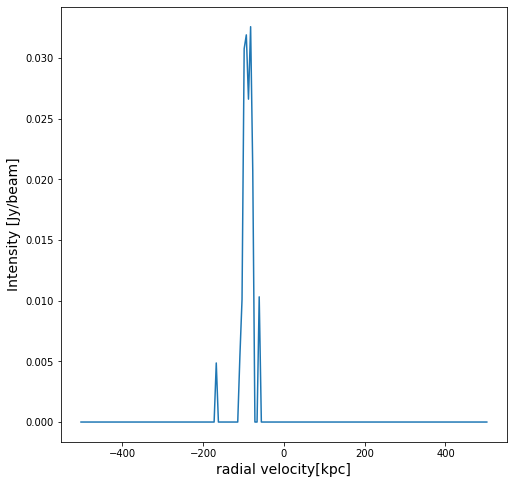

In [15]:
plt.figure(figsize=(8,8))
plt.plot(vv,pvd_cubec[:,40]) #Spectrum of one pixel
plt.xlabel('radial velocity[kpc]',fontsize=14), plt.ylabel('Intensity [Jy/beam]',fontsize=14)
plt.show()

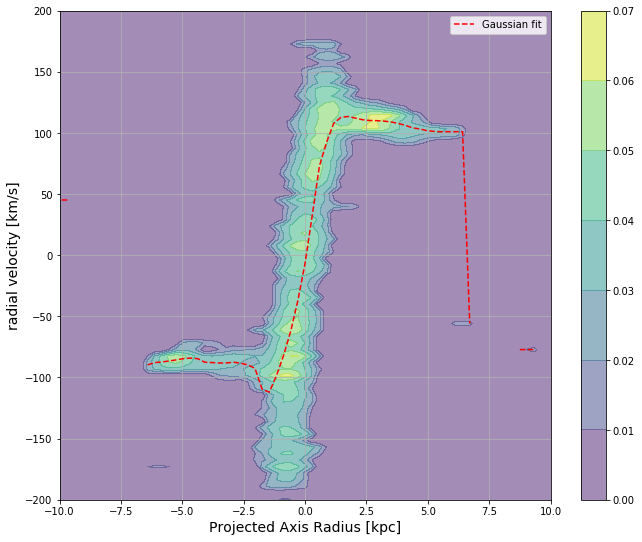

In [16]:
import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

def gaus(x,a,x0,sigma):
    return a * np.exp(-(x-x0)**2/(2 * sigma**2))                                               
vv_slit=np.linspace(0,0,len(yy_kpc))                                                            

for k in range(len(yy_kpc)):
    mean=np.nansum(vv*pvd_cubec[:,k])/np.nansum(pvd_cubec[:,k])
    sig=np.sqrt(np.nansum(pvd_cubec[:,k] * (vv - mean)**2) /np.nansum(pvd_cubec[:,k]))
    popt,pcov = curve_fit(gaus,vv,pvd_cubec[:,k],p0=[np.nanmax(pvd_cubec[:,k]),mean,sig])
    vv_slit[k]=popt[1]
    
plt.figure(figsize=(11,9))
l1=plt.plot(yy_kpc,vv_slit,'r--',label='Gaussian fit')
plt.contourf(yy_kpc,vv,pvd_cubec,alpha=0.5), plt.colorbar()
plt.xlim(-10,10), plt.ylim(-200,200), plt.grid()
plt.xlabel('Projected Axis Radius [kpc]',fontsize=14), plt.ylabel('radial velocity [km/s]',fontsize=14)
plt.legend(handles=l1, loc='upper right')

plt.show()

### Optical Image & CO(1-0) moment 0

In [17]:
opticalfits=["g.fits","r.fits","i.fits","z.fits"]

g_fits=fits.open(datafolder+'optical/'+opticalfits[0])
r_fits=fits.open(datafolder+'optical/'+opticalfits[1])
i_fits=fits.open(datafolder+'optical/'+opticalfits[2])
z_fits=fits.open(datafolder+'optical/'+opticalfits[3])

#fits.HDUList.info(r_fits)

gheader=g_fits[0].header
rheader=r_fits[0].header
iheader=i_fits[0].header
zheader=z_fits[0].header

gdata=g_fits[0].data
rdata=r_fits[0].data
idata=i_fits[0].data
zdata=z_fits[0].data

g_fits.close()
r_fits.close()
i_fits.close()
z_fits.close()

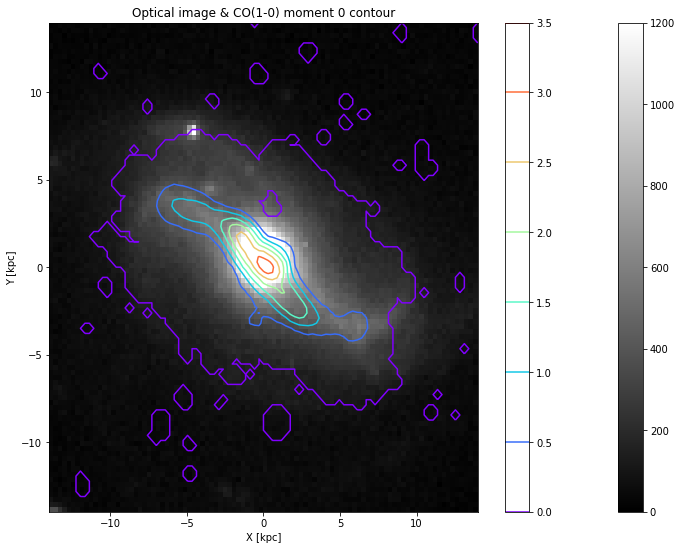

In [18]:
final_image=gdata+rdata+idata+zdata
plt.figure(figsize=(12,9))
center=[np.int(rheader["CRPIX1"]),np.int(rheader["CRPIX1"])]
final_image2=final_image[center[0]-48:center[0]+48, center[0]-48:center[0]+48]

plt.pcolormesh(xx_kpc,yy_kpc,final_image2,cmap='gray',vmin=0,vmax=1200), plt.colorbar()
plt.contour(xx_kpc,yy_kpc,np.rot90(mrk79_mom0,k=2,axes=(0,1)),cmap='rainbow'), plt.colorbar()
plt.xlabel("X [kpc]"), plt.ylabel("Y [kpc]"), plt.title("Optical image & CO(1-0) moment 0 contour")
display()

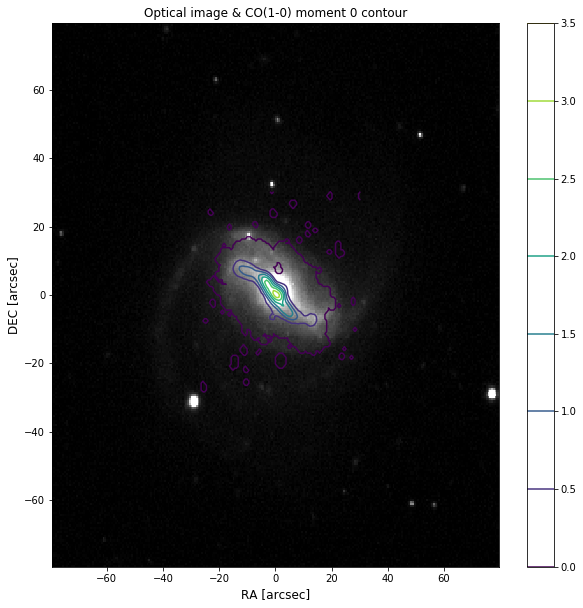

In [19]:
plt.figure(figsize=(10,10))
xx1=np.linspace(-rdata.shape[1]*dx/2.,rdata.shape[1]*dx/2.,255)#*ak #arcsec
yy1=np.linspace(-rdata.shape[1]*dx/2.,rdata.shape[1]*dx/2.,255)#*ak 
plt.pcolormesh(xx1,yy1,final_image,cmap='gray',vmin=0,vmax=800)
plt.contour(xx,yy,np.rot90(mrk79_mom0,k=-2,axes=(0,1))), plt.colorbar()
plt.xlabel("RA [arcsec]",fontsize=12), plt.ylabel("DEC [arcsec]",fontsize=12), plt.title("Optical image & CO(1-0) moment 0 contour")
display()